In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_absolute_error
from scipy.stats import spearmanr, pearsonr
from datetime import datetime
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

In [5]:
class TransformerDecoder(nn.Module):
    def __init__(self, d_model, heads, forward_expansion, dropout, max_length):
        super(TransformerDecoder, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=heads, dropout=dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, forward_expansion * d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion * d_model, d_model)
        )

        self.dropout = nn.Dropout(dropout)

        # Additional linear layer for output transformation
        self.output_transform = nn.Linear(d_model, 18)

        # Adaptive pooling layer to handle sequence length
        self.sequence_pooling = nn.AdaptiveAvgPool1d(1)

    def forward(self, x, enc_out=None, src_mask=None, trg_mask=None):
        attention_output, _ = self.attention(x, x, x, attn_mask=trg_mask)
        query = self.dropout(self.norm1(attention_output + x))

        out = self.feed_forward(query)
        out = self.dropout(self.norm2(out + query))

        out_transformed = self.output_transform(out)

        out_pooled = self.sequence_pooling(out_transformed.transpose(1, 2)).transpose(1, 2)

        return out_pooled

In [6]:
import h5py

In [7]:
def load_data(file_path, dataset_name, start=0, chunk_size=None):
    with h5py.File(file_path, 'r') as file:
        if chunk_size is not None:
            data = file[dataset_name][start:start+chunk_size]
        else:
            data = file[dataset_name][:]
    return data


# # Load embeddings. The code below is for loading all embeddings directly from the beginning. Currently, embeddings are produced on training runs.
# embeddings = load_data('/content/drive/My Drive/basenji transformer stuff/datasets/embeddings200.h5', 'embeddings')

# # Load labels
# labels_single_bin = load_data('/content/drive/My Drive/basenji transformer stuff/datasets/dataset_14-lmnb1_4-cpg.h5', 'single_bin')

In [11]:
f = h5py.File('/clusterfs/nilah/oberon/datasets/basenji/embeddings/embeddings.h5','r')
dset = f['embeddings']

train_inds = np.zeros(len(dset), dtype=bool)
val_inds = np.zeros(len(dset), dtype=bool)
test_inds = np.zeros(len(dset), dtype=bool)

train_inds[:34021]=True
val_inds[34021:36234]=True
test_inds[36234:]=True

labels_full = h5py.File('/clusterfs/nilah/oberon/datasets/cs282a/dataset_14-lmnb1_4-cpg.h5')['single_bin']

start_load = datetime.now()
print('starting at ',start_load)
val_tensor_dset = torch.utils.data.TensorDataset(torch.Tensor(dset[val_inds]), torch.Tensor(labels_full[val_inds]))
print(datetime.now()-start_load)
test_tensor_dset = torch.utils.data.TensorDataset(torch.Tensor(dset[test_inds]), torch.Tensor(labels_full[test_inds]))
print(datetime.now()-start_load)
train_tensor_dset = torch.utils.data.TensorDataset(torch.Tensor(dset[train_inds]), torch.Tensor(labels_full[train_inds]))
print(datetime.now()-start_load)
training_loader = torch.utils.data.DataLoader(train_tensor_dset, batch_size=4, shuffle=True)
print(datetime.now()-start_load)
validation_loader = torch.utils.data.DataLoader(val_tensor_dset, batch_size=4, shuffle=False)
print(datetime.now()-start_load)
test_loader = torch.utils.data.DataLoader(test_tensor_dset, batch_size=4, shuffle=False)
print(datetime.now()-start_load)

starting at  2023-11-28 07:42:11.677318
0:00:33.070168
0:01:01.845817
0:23:01.125770
0:23:01.133266
0:23:01.133506
0:23:01.169850


In [ ]:
# # Parameters
# total_size = 36234  # Total size of your dataset
# chunk_size = 1024  # Define your chunk size based on memory capacity
# batch_size = 32    # Define your batch size
# split_idx = 34021    # Assuming 160 samples for training and 40 for validation

# # Shuffle and split indices for training and validation
# indices = torch.randperm(total_size).tolist()
# train_indices = set(indices[:split_idx])
# val_indices = set(indices[split_idx:])

# Initialize model, optimizer, and loss function
basenji_transformer = TransformerDecoder(d_model=1536, heads=6, forward_expansion=2, dropout=0.2, max_length=896)
optimizer = torch.optim.Adam(basenji_transformer.parameters(), lr=0.001)
loss_function = torch.nn.MSELoss()

# Training and validation
num_epochs = 10
best_vloss = 1_000_000.
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/mlp_model_{}'.format(timestamp))
train_loss_list = []
val_loss_list = []


for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")
    
    # Training
    basenji_transformer.train()
    total_loss_train, total_samples_train = 0, 0
    all_targets_train, all_predictions_train = [], []

    for i, data in tqdm(enumerate(training_loader),desc=f'training epoch {epoch}',total=np.sum(train_inds)/4):
        batch, target = data

        optimizer.zero_grad()
        output = basenji_transformer(batch)
        loss_value = loss_function(output, target)
        loss_value.backward()
        
        # Apply torch.nan_to_num to gradients
        for param in basenji_transformer.parameters():
            if param.grad is not None:
                param.grad = torch.nan_to_num(param.grad)
        
        optimizer.step()

        total_loss_train += loss_value.item() * batch.size(0)
        total_samples_train += batch.size(0)

        all_predictions_train.extend(torch.nan_to_num(output).detach().cpu().numpy())
        all_targets_train.extend(torch.nan_to_num(target).cpu().numpy())

    avg_loss_train = total_loss_train / total_samples_train
    train_loss_list.append(avg_loss_train)
    train_mae = mean_absolute_error(np.vstack(all_targets_train), np.vstack(all_predictions_train))
    
    
    ptrain_corr,_ = pearsonr(np.array(all_predictions_train).flatten(),np.array(all_targets_train).flatten())
    strain_corr,_ = spearmanr(np.array(all_predictions_train).flatten(),np.array(all_targets_train).flatten())
    
    print(f"Training Loss: {avg_loss_train}, Training MAE: {train_mae}, Pearson correlation: {ptrain_corr}, Spearman correlation: {strain_corr}")

    # Validation
    basenji_transformer.eval()
    total_loss_val, total_samples_val = 0, 0
    all_targets_val, all_predictions_val = [], []

    for i, vdata in tqdm(enumerate(validation_loader),desc=f'validating epoch{epoch}',total=np.sum(val_inds)/4):
        with torch.no_grad():
            batch, target = vdata

            output = basenji_transformer(batch)
            loss_value = loss_function(output, target)
            total_loss_val += loss_value.item() * batch.size(0)
            total_samples_val += batch.size(0)

            all_predictions_val.extend(torch.nan_to_num(output).detach().cpu().numpy())
            all_targets_val.extend(torch.nan_to_num(target).cpu().numpy())

    avg_loss_val = total_loss_val / total_samples_val
    val_loss_list.append(avg_loss_val)
    val_mae = mean_absolute_error(np.vstack(all_targets_val), np.vstack(all_predictions_val))
    
    pval_corr,_ = pearsonr(np.array(all_predictions_val).flatten(),np.array(all_targets_val).flatten())
    sval_corr,_ = spearmanr(np.array(all_predictions_val).flatten(),np.array(all_targets_val).flatten())
    
    if avg_loss_val < best_vloss:
        best_vloss = avg_loss_val
        model_path = 'model_{}_{}'.format(timestamp, epoch)
        torch.save(basenji_transformer.state_dict(), model_path)
        
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss_train, 'Validation' : avg_loss_val },
                    epoch + 1)
    writer.flush()

    print(f"Validation Loss: {avg_loss_val}, Validation MAE: {val_mae}, Pearson correlation: {pval_corr}, Spearman correlation: {sval_corr}")

Epoch 1
-------------------------------


training epoch 0: 8506it [1:25:10,  1.66it/s]                             


Training Loss: nan, Training MAE: 15.354476928710938, Pearson correlation: 0.9400688422277668, Spearman correlation: 0.911699149009928


validating epoch0: 554it [00:37, 14.89it/s]                            


Validation Loss: 529.8968188686173, Validation MAE: 15.633580207824707, Pearson correlation: 0.9477034922349774, Spearman correlation: 0.9168417617607615
Epoch 2
-------------------------------


training epoch 1: 8506it [1:26:56,  1.63it/s]                               


Training Loss: nan, Training MAE: 13.98198127746582, Pearson correlation: 0.952980836825945, Spearman correlation: 0.9271632714830261


validating epoch1: 554it [00:38, 14.29it/s]                            


Validation Loss: 514.7512879990045, Validation MAE: 15.280576705932617, Pearson correlation: 0.9486305976775996, Spearman correlation: 0.9196919827529264
Epoch 3
-------------------------------


training epoch 2:  52%|█████▏    | 4381/8505.25 [38:22<36:53,  1.86it/s]  

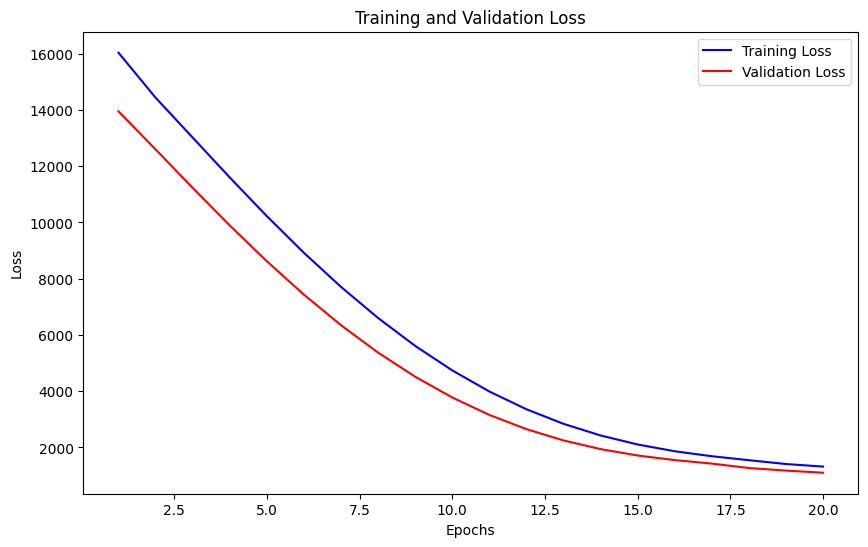

In [ ]:
import matplotlib.pyplot as plt

# Assuming train_loss_list and val_loss_list are filled with loss values from your training loop
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_list, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_list, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()